# LSTM with Tweet Volume

In [82]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers
from mongo_db import MongoDB

def createTrainingData(dataset: pd.Series):
    training_data_len = math.ceil(len(dataset.values)* 0.8)
    scaler = MinMaxScaler(feature_range=(0,1))
    print(dataset)
    train_data = dataset[0: training_data_len]

    x_train = []
    y_train = []

    for i in range(48, len(train_data)):
        x_train.append(train_data[i-48:i])
        y_train.append(train_data[i])
        
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    return x_train, y_train, training_data_len

def createTestData(scaled_data: pd.Series, training_data_len, values):
    test_data = scaled_data[training_data_len-48:]
    x_test = []
    y_test = values[training_data_len:]

    for i in range(48, len(test_data)):
        x_test.append(test_data[i-48:i])

    x_test = np.array(x_test)
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
    
    return x_test, y_test

tweets = pd.read_csv('analzyed.csv', sep=',')
pricedata = pd.read_csv('lrc_snapshot_2_Nov_9_15.csv', sep=',')

Text(0, 0.5, 'Sentiment')

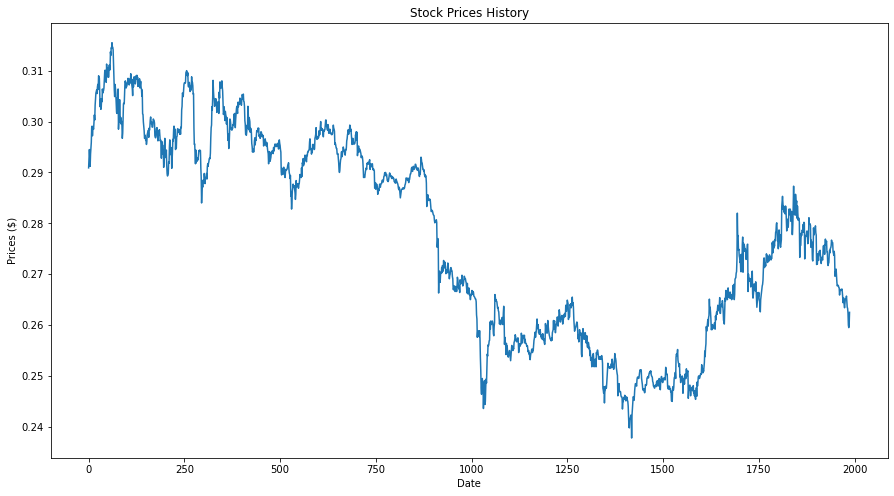

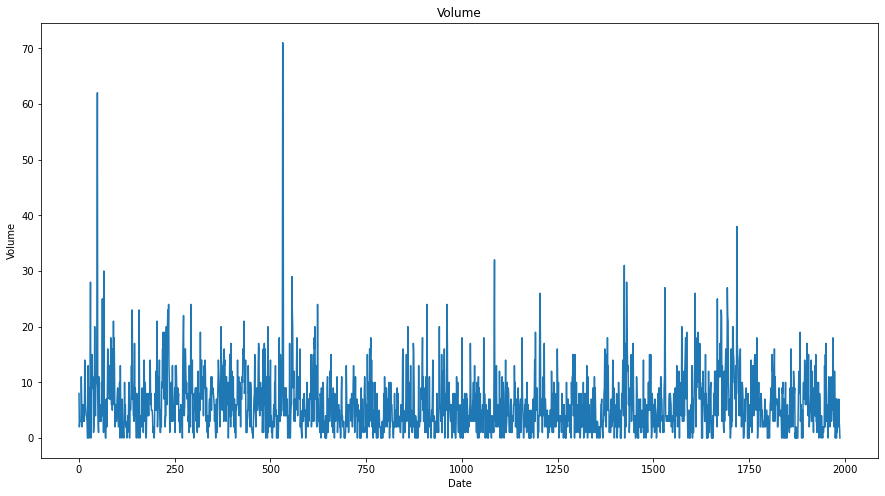

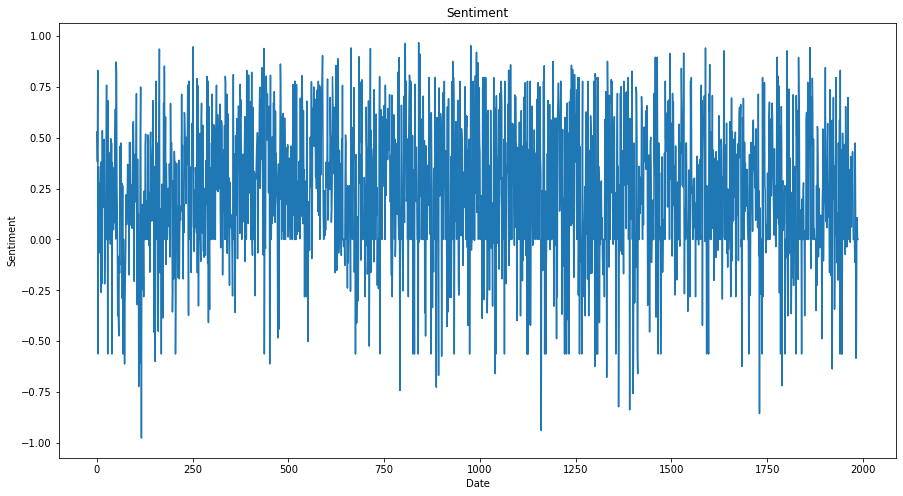

In [83]:
price_data_numeric = pd.to_numeric(pricedata['price'])
volume_numeric = pd.to_numeric(tweets['Volume'])
sentiment_numeric = pd.to_numeric(tweets['Sentiment'])

plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(price_data_numeric)
plt.xlabel('Date')
plt.ylabel('Prices ($)')

plt.figure(figsize=(15, 8))
plt.title('Volume')
plt.plot(volume_numeric)
plt.xlabel('Date')
plt.ylabel('Volume')

plt.figure(figsize=(15, 8))
plt.title('Sentiment')
plt.plot(sentiment_numeric)
plt.xlabel('Date')
plt.ylabel('Sentiment')

In [84]:
x_train_volume, y_train_volume, training_data_len_volume = createTrainingData(volume_numeric)
x_train_price, y_train_price, training_data_len_price = createTrainingData(price_data_numeric)
x_train_sentiment, y_train_sentiment, training_data_len_sentiment = createTrainingData(sentiment_numeric)

x_test_volume, y_test_volume = createTestData(volume_numeric, training_data_len_volume, volume_numeric)
x_test_price, y_test_price = createTestData(price_data_numeric, training_data_len_price, price_data_numeric)
x_test_sentiment, y_test_sentiment = createTestData(sentiment_numeric, training_data_len_sentiment, sentiment_numeric)

print(x_train_volume)
print(x_test_price)
print(x_test_sentiment)

input1 = layers.Input(shape=(x_train_price.shape[1], 1))
input2 = layers.Input(shape=(x_train_volume.shape[1], 1))
input3 = layers.Input(shape=(x_train_sentiment.shape[1], 1))
input = keras.layers.Concatenate()([input1, input2, input3])
lstm_layer1 = layers.LSTM(100, return_sequences=True)(input)
lstm_layer2 = layers.LSTM(100, return_sequences=False)(lstm_layer1)
dense_layer_1 = layers.Dense(25)(lstm_layer2)
output = layers.Dense(1)(dense_layer_1)
model = keras.models.Model(inputs=[input1, input2, input3], outputs=output)

model.summary()

0       8
1       2
2       3
3       3
4       3
       ..
1983    2
1984    7
1985    3
1986    2
1987    0
Name: Volume, Length: 1988, dtype: int64
0       0.2909
1       0.2926
2       0.2945
3       0.2931
4       0.2912
         ...  
1983    0.2624
1984    0.2600
1985    0.2595
1986    0.2599
1987    0.2625
Name: price, Length: 1988, dtype: float64
0       0.527988
1       0.382500
2       0.830900
3      -0.562900
4       0.357667
          ...   
1983   -0.542300
1984    0.029914
1985    0.106833
1986    0.000000
1987    0.000000
Name: Sentiment, Length: 1988, dtype: float64
[[[ 8]
  [ 2]
  [ 3]
  ...
  [10]
  [10]
  [22]]

 [[ 2]
  [ 3]
  [ 3]
  ...
  [10]
  [22]
  [62]]

 [[ 3]
  [ 3]
  [ 3]
  ...
  [22]
  [62]
  [ 7]]

 ...

 [[ 4]
  [ 7]
  [ 8]
  ...
  [17]
  [ 7]
  [19]]

 [[ 7]
  [ 8]
  [ 3]
  ...
  [ 7]
  [19]
  [ 7]]

 [[ 8]
  [ 3]
  [ 8]
  ...
  [19]
  [ 7]
  [ 3]]]
[[[0.2524]
  [0.2498]
  [0.2502]
  ...
  [0.246 ]
  [0.2488]
  [0.248 ]]

 [[0.2498]
  [0.2502]
  [0.24

In [85]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit([x_train_price, x_train_volume, x_train_sentiment], y_train_price, batch_size = 16, epochs=100, validation_data=([x_train_price, x_train_volume, x_train_sentiment], y_train_price))

Epoch 1/100
97/97 [==============================] - 4s 28ms/step - loss: 0.0113 - val_loss: 5.3770e-04
Epoch 2/100
97/97 [==============================] - 2s 26ms/step - loss: 5.0996e-04 - val_loss: 4.2257e-04
Epoch 3/100
97/97 [==============================] - 2s 25ms/step - loss: 4.1427e-04 - val_loss: 4.6559e-04
Epoch 4/100
97/97 [==============================] - 2s 24ms/step - loss: 4.1060e-04 - val_loss: 3.3304e-04
Epoch 5/100
97/97 [==============================] - 2s 24ms/step - loss: 3.5082e-04 - val_loss: 4.9094e-04
Epoch 6/100
97/97 [==============================] - 2s 24ms/step - loss: 3.3710e-04 - val_loss: 3.5619e-04
Epoch 7/100
97/97 [==============================] - 2s 21ms/step - loss: 4.1496e-04 - val_loss: 3.3889e-04
Epoch 8/100
97/97 [==============================] - 2s 23ms/step - loss: 3.3056e-04 - val_loss: 2.3497e-04
Epoch 9/100
97/97 [==============================] - 2s 24ms/step - loss: 2.7107e-04 - val_loss: 1.8697e-04
Epoch 10/100
97/97 [============

In [86]:
predictions = model.predict((x_test_price, x_test_volume, x_test_sentiment))
print(predictions)
rmse = np.sqrt(np.mean(predictions[0] - y_test_price)**2)
rmse

13/13 [==============================] - 0s 7ms/step
[[0.258397  ]
 [0.25728443]
 [0.25645992]
 [0.25648323]
 [0.25526902]
 [0.25526416]
 [0.25381136]
 [0.25319594]
 [0.2534556 ]
 [0.25389013]
 [0.2524803 ]
 [0.25459048]
 [0.254224  ]
 [0.2546003 ]
 [0.2534638 ]
 [0.25193742]
 [0.25297135]
 [0.25548542]
 [0.25840303]
 [0.26308033]
 [0.26557618]
 [0.26402026]
 [0.2651382 ]
 [0.26523584]
 [0.2669938 ]
 [0.2681059 ]
 [0.26803792]
 [0.27050123]
 [0.2712138 ]
 [0.27236181]
 [0.2716584 ]
 [0.27318668]
 [0.2729262 ]
 [0.27297094]
 [0.27221757]
 [0.2721609 ]
 [0.27054134]
 [0.2698392 ]
 [0.26833302]
 [0.26956525]
 [0.26986215]
 [0.26920143]
 [0.26900497]
 [0.2680448 ]
 [0.26674226]
 [0.26648897]
 [0.2698814 ]
 [0.269984  ]
 [0.2697687 ]
 [0.2682544 ]
 [0.2658805 ]
 [0.2664867 ]
 [0.2654054 ]
 [0.2659359 ]
 [0.26811275]
 [0.26842266]
 [0.26729357]
 [0.26664144]
 [0.26721072]
 [0.2691105 ]
 [0.27039954]
 [0.2694867 ]
 [0.26726186]
 [0.26609805]
 [0.26484534]
 [0.2651118 ]
 [0.26434746]
 [0.26433

0.01227427168577084

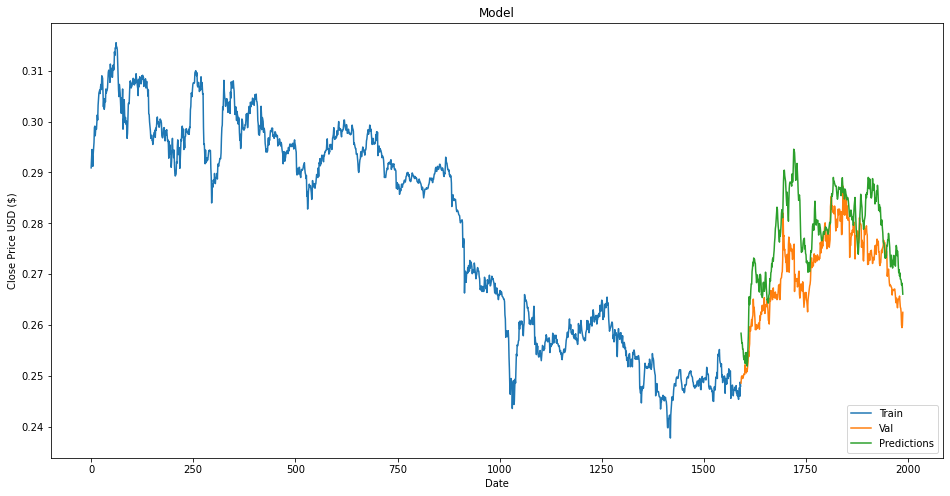

In [87]:
data = price_data_numeric
train = data[:training_data_len_price]
validation = pd.DataFrame()
validation['price'] = data[training_data_len_price:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[['price', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

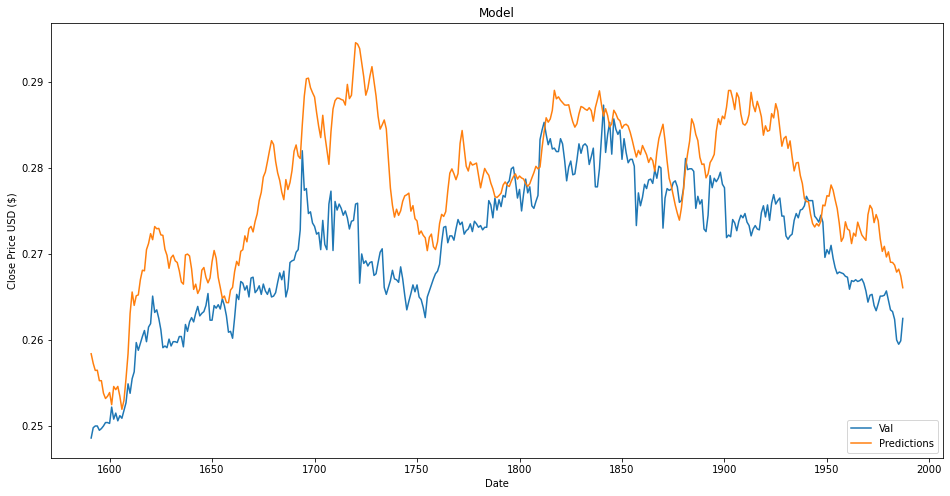

In [88]:
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(validation[['price', 'Predictions']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()